In [1]:
import seaborn as sbn
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import subprocess
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.ticker as mtick
from scipy.interpolate import interp1d, splev, CubicSpline, PPoly
#import metpy

from ngs import HiCTools as HT

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi
import skimage
from skimage import io, filters, morphology
from glob import glob
import seaborn as sns
from scipy import stats
from scipy.signal import chirp, find_peaks, peak_widths, savgol_filter
import pandas as pd
from pathlib import Path
import scipy.stats


ATTENTION: You need to run a high memory kernel

TODO: Figure out why this des not work for pbgzip!

In [2]:
import shutil
shutil.which('pbgzip')   
shutil.which('lz4c')

#Since pairtools/_fileio.py checks for this
#if shutil.which('pbgzip') is None:
#            raise ValueError({
#                'w':'pbgzip is not found, cannot compress output',
#                'a':'pbgzip is not found, cannot compress output',
#                'r':'pbgzip is not found, cannot decompress input'
#                    }[mode])

'/opt/conda/bin/lz4c'

Remark: I made a copy of ther *pairs.gz into unzip/ (to be save because our gzip version is <1.6 and has no -k flag). And this script now only works with unziped pairsam files until IT installs pbgzip since in the jupyter kernel will not find the version installed with conda. Or we rewrite Antons tool to use a different bzip. (would be in pairtools/_fileio.py)

Now we will load the data:

In [4]:
pairDir = {"WT_mitotic_rep1_TAGCTT_S1": "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig4/cis_trans_pairs_mitotic/",
           "WT_mitotic_rep2_AGTCAA_S2": "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig4/cis_trans_pairs_mitotic/",
           "SMC4_plus_mitotic_rep1_GTCCGC_S8" : "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig4/cis_trans_pairs_mitotic/",
           "SMC4_plus_mitotic_rep2_GTGAAA_S5" :  "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig4/cis_trans_pairs_mitotic/",
           "GTGGCC_S11" : "/groups/gerlich/sequencing_data/49/scshic_pipeline/nf-out/546819-Novaseq/cis_trans_pairs/unzipped/",
           "GAGTGG_S12" : "/groups/gerlich/sequencing_data/49/scshic_pipeline/nf-out/546819-Novaseq/cis_trans_pairs/unzipped/",
           "GGTAGC_S13" : "/groups/gerlich/sequencing_data/49/scshic_pipeline/nf-out/546819-Novaseq/cis_trans_pairs/unzipped/"
          }


sampleMapping = {"WT_mitotic_rep1_TAGCTT_S1": "WT_short_mitosis_rep1",
                 "WT_mitotic_rep2_AGTCAA_S2": "WT_short_mitosis_rep2",
                 "SMC4_plus_mitotic_rep1_GTCCGC_S8": "SMC4_AID_plus_aux_short_mitosis_rep1",
                 "SMC4_plus_mitotic_rep2_GTGAAA_S5": "SMC4_AID_plus_aux_short_mitosis_rep2",
                 "GTGGCC_S11" : "NIPBL_dep_60min_mitosis_rep1",
                 "GAGTGG_S12" : "NIPBL_dep_60min_mitosis_rep2",
                 "GGTAGC_S13" : "NIPBL_dep_60min_mitosis_rep3"
                 }

             
pairs = {}
for barcode, name in sampleMapping.items():
    pairs[name] = {}
    pairs[name]["cis"] = HT.load_pairs(
        os.path.join(pairDir[barcode], f"{barcode}.cis.pairs"))
    pairs[name]["trans"] = HT.load_pairs(
        os.path.join(pairDir[barcode], f"{barcode}.trans.pairs"))


In [5]:
pairsMerged = {}

pairsMerged["WT_short_prometa"] = {}
pairsMerged["WT_short_prometa"]["cis"] = pd.concat((pairs["WT_short_mitosis_rep1"]["cis"], pairs["WT_short_mitosis_rep2"]["cis"]))
pairsMerged["WT_short_prometa"]["trans"]=pd.concat((pairs["WT_short_mitosis_rep1"]["trans"], pairs["WT_short_mitosis_rep2"]["trans"]))

pairsMerged["SMC4_depleted_short_prometa"] = {}
pairsMerged["SMC4_depleted_short_prometa"]["cis"] = pd.concat((pairs["SMC4_AID_plus_aux_short_mitosis_rep1"]["cis"], pairs["SMC4_AID_plus_aux_short_mitosis_rep2"]["cis"]))
pairsMerged["SMC4_depleted_short_prometa"]["trans"] = pd.concat((pairs["SMC4_AID_plus_aux_short_mitosis_rep1"]["trans"], pairs["SMC4_AID_plus_aux_short_mitosis_rep2"]["trans"]))

pairsMerged["NIPBL_depleted_short_prometa"] = {}
pairsMerged["NIPBL_depleted_short_prometa"]["cis"] = pd.concat((pairs["NIPBL_dep_60min_mitosis_rep1"]["cis"], pairs["NIPBL_dep_60min_mitosis_rep2"]["cis"], pairs["NIPBL_dep_60min_mitosis_rep3"]["cis"]))
pairsMerged["NIPBL_depleted_short_prometa"]["trans"] = pd.concat((pairs["NIPBL_dep_60min_mitosis_rep1"]["trans"], pairs["NIPBL_dep_60min_mitosis_rep2"]["trans"], pairs["NIPBL_dep_60min_mitosis_rep3"]["trans"]))

Prepare data for plotting:

In [6]:

# downsample pairs --> use this if you have multiple samples
# then pairs needs to be a nested dictionary {sample: {cis: pairFrame, trans:pairFrame}}

downsampled = HT.down_sample_pairs(pairsMerged, distance=1000)

# get chromosome features

hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.get_arms_hg19()

# calculate scaling plots

scs = {sample: {rType: pairlib.scalings.compute_scaling(
       downsampled[sample][rType],
       arms,
       hg19_chromsizes, n_dist_bins=40
       ) for rType in ["cis", "trans"]}
       for sample in downsampled.keys()}


# aggregate scaling plots

sc_agg = {sample: {rType: (scs[sample][rType][0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
          for rType in scs[sample].keys()
          } for sample in scs.keys()
          }

# calculate x-Values and contact probability

plotData = {sample: {rType: (np.sqrt(sc_agg[sample][rType].min_dist * sc_agg[sample][rType].max_dist),
            sc_agg[sample][rType].n_pairs / sc_agg[sample][rType].n_bp2)
            for rType in sc_agg[sample].keys()
            } for sample in sc_agg.keys()
                        }


/users/paul.batty/.conda/envs/cooltools/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Setup apearance for plots

In [7]:
# colormap for plots
colorMap = {"cis": "gray",
            "trans": "black"}

Plot cis and trans per condition:

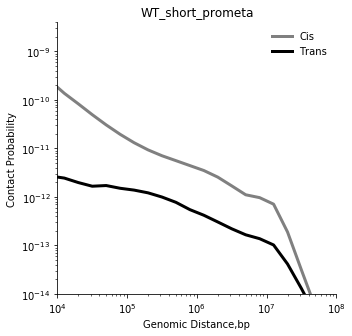

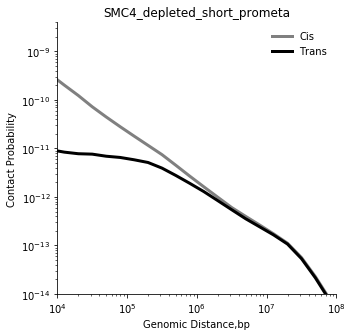

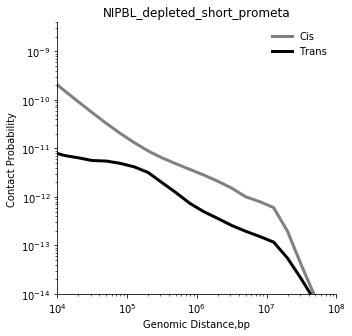

In [8]:
for sample in plotData.keys():
    f, ax = plt.subplots(1,1)
    for rType in ["cis", "trans"]:
        ax.loglog(plotData[sample][rType][0],
                plotData[sample][rType][1],
                label=f'{rType.capitalize()}', color=colorMap[rType], lw=3
                )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 100000000)
    ax.set_ylim(10**(-14), 4 * 10**(-9))
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Contact Probability")
    f.set_size_inches(5, 5)
    sbn.despine()
    plt.title(sample)
    f.show
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/supplementary_figures/fig_ev9/plots/"
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.png"), bbox_inches="tight")
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.pdf"), bbox_inches="tight")

Now we plot cis/trans per condition:

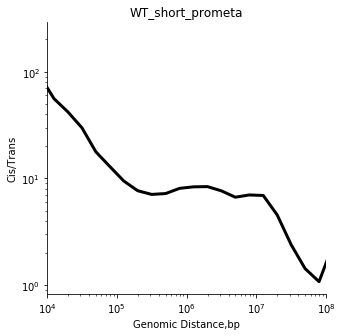

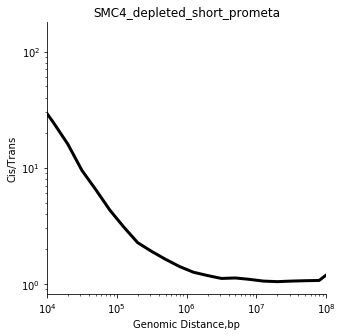

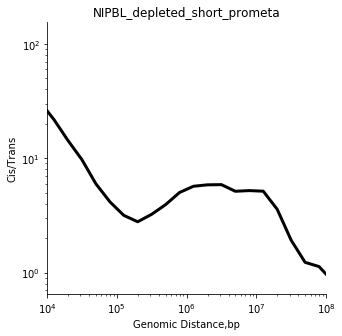

In [9]:
for sample in plotData.keys():
    f, ax = plt.subplots(1,1)
    for rType in ["trans"]:
        ax.loglog(plotData[sample][rType][0],
                plotData[sample]["cis"][1]/plotData[sample]["trans"][1],
                label=f'{rType.capitalize()}', color=colorMap[rType], lw=3
                )
    ax.grid(lw=0.5, color='gray')
    ax.set_xlim(10000, 100000000)
    ax.grid(False)
    #ax.set_ylim(10**(-15), 4 * 10**(-10))
    #ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Cis/Trans")
    f.set_size_inches(5, 5)
    sbn.despine()
    plt.title(sample)
    f.show
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/supplementary_figures/fig_ev9/plots/"
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.png"), bbox_inches="tight")
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.pdf"), bbox_inches="tight")

In [11]:
# colormap for plots
colorMap2 = {"WT_short_prometa": "black",
            "SMC4_depleted_short_prometa": "red",
            "NIPBL_depleted_short_prometa" : "blue"}

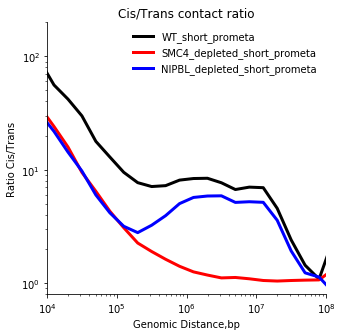

In [14]:
f, ax = plt.subplots(1,1)
for sample in plotData.keys():
    for rType in ["trans"]:
        ax.loglog(plotData[sample][rType][0],
            plotData[sample]["cis"][1]/plotData[sample][rType][1],
            label=f'{sample}', lw=3, color = colorMap2[sample]
            )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 100000000)
    ax.set_ylim(0.8, 200)
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Ratio Cis/Trans")
    f.set_size_inches(5, 5)
    sbn.despine()
    plt.title('Cis/Trans contact ratio')
    f.show()
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/supplementary_figures/fig_ev9/plots/"
    f.savefig(os.path.join(resultsdir, "ratio_plots_g2_wt_nipbl_smc4_dep_prometa.png"), bbox_inches="tight")
    f.savefig(os.path.join(resultsdir, "ratio_plots_g2_wt_nipbl_smc4_dep_prometa.pdf"), bbox_inches="tight")